In [36]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [37]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [38]:
# Ignore SQLITE warnings related to Decimal numbers in the Hawaii database
import warnings
warnings.filterwarnings('ignore')

In [39]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [40]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [41]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine, reflect = True)


In [42]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [43]:
# Save references to each table

# Save a reference to the measurement table as `Measurement`
Measurement = Base.classes.measurement

# Save a reference to the station table as `Station`
Station = Base.classes.station

In [44]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [45]:
# Find the 'date' column in tables:

if 'date' in Measurement.__table__.columns:
    print("'date' column exists in the 'measurement' table.")

if 'date' in Station.__table__.columns:
    print("'date' column exists in the 'station' table.")

'date' column exists in the 'measurement' table.


In [46]:
# Find the most recent date in the data set.

most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(most_recent_date)

('2017-08-23',)


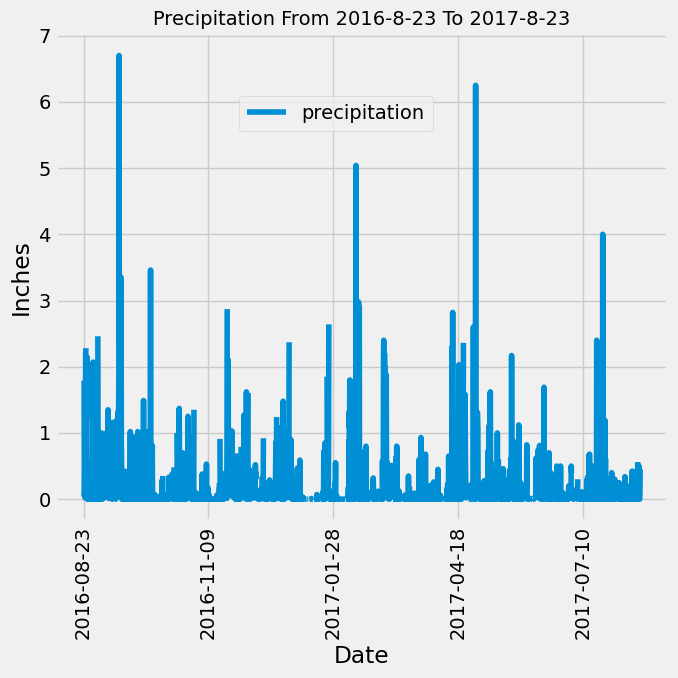

In [47]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.

from datetime import datetime, timedelta

 
# Calculate the date one year from the last date in data set.
most_recent_date_str = most_recent_date[0]
most_recent_date = datetime.strptime(most_recent_date_str, '%Y-%m-%d')
one_year_ago = most_recent_date - timedelta(days=366)

# Perform a query to retrieve the date and precipitation scores
date_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago, Measurement.date <= most_recent_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(date_prcp, columns=['date', 'precipitation'])

# Sort the dataframe by date
date_sorted_df = df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
date_sorted_df.plot(x='date', y='precipitation', figsize=(7, 7))
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Precipitation From 2016-8-23 To 2017-8-23', fontsize=14)
plt.legend(loc=(0.3, 0.8))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [48]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = date_sorted_df['precipitation'].describe()
display(pd.DataFrame(summary_statistics))

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [49]:
# Design a query to calculate the total number of stations in the dataset
num_station = session.query(func.count(Station.station)).all()
num_station

[(9,)]

In [50]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
station_counts


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [51]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = station_counts[0][0]
print(f'The most active station: {most_active_station}\n')

# Lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs),
                                  func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).\
                                  filter(Measurement.station == most_active_station).all()

print(temperature_stats)

The most active station: USC00519281

[(54.0, 85.0, 71.66378066378067)]


{'mean': 73.2, 'median': 74.0, 'mode': 74}


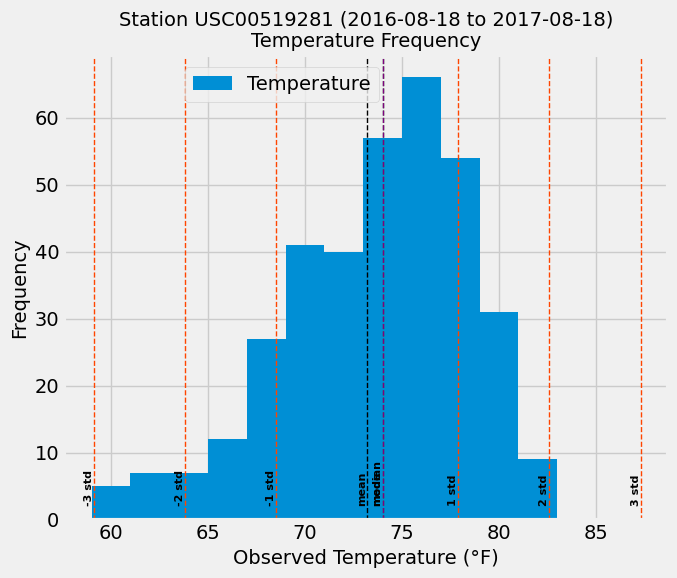

In [52]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# The most active station: USC00519281

from datetime import datetime, timedelta

#Last recorded date
station_date_last = session.query(Measurement.date).\
                    order_by(Measurement.date.desc()).\
                    filter(Measurement.station == most_active_station).first()

station_date_last_str = station_date_last[0]
station_date_last = datetime.strptime(station_date_last_str, '%Y-%m-%d')

# Date a year ago
station_date_year_ago = station_date_last - timedelta(days=365)

# Query the "tobs" data for the last year
tobs_data = session.query(Measurement.tobs).\
            filter(Measurement.station == most_active_station,
                   Measurement.date >= station_date_year_ago,
                   Measurement.date <= station_date_last).all()

# Extract the temperatures from the result
temperatures = [int(temp[0]) for temp in tobs_data]
bin_size = (max(temperatures) - min(temperatures))//12

# Create a histogram plot
plt.figure(figsize=(7, 6))
plt.hist(temperatures, bins=range(min(temperatures), max(temperatures) + 2, bin_size), edgecolor = None)
plt.title(f'Station {most_active_station} ({station_date_year_ago.date()} to {station_date_last.date()})\nTemperature Frequency', fontsize=14)
plt.xlabel('Observed Temperature (\u00b0F)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(['Temperature'], loc=(0.2, 0.9))
plt.grid(True)
plt.tight_layout()

#---------------------------------------------------------------------------

from scipy import stats

# Calculate mean, median, mode, and standard deviation using numpy and scipy.stats
mean = np.mean(temperatures).round(1)
median = np.median(temperatures).round(1)
mode = stats.mode(temperatures)[0][0].round(1)
std = np.std(temperatures).round(1)

stat_param = {'mean': mean, 'median': median, 'mode': mode}
print(stat_param)

for i in range(-4, 3):
    if (i + 1) == 0:
        continue
    else:
        new_val = (mean + (i + 1) * std).round(1)
        new_key = f'{i + 1} std'
        stat_param[new_key] = new_val


ln_clr = ['black', 'forestgreen', 'purple', 'orangered', 'orangered', 'orangered', 'orangered', 'orangered', 'orangered']

for i, (k, v) in enumerate(stat_param.items()):

    plt.axvline(v, color=ln_clr[i], linestyle='dashed', lw = 1.00)
    plt.text(v, 2, k, color='k', ha='right', va='bottom', rotation=90, fontsize=8, weight = 'bold')

plt.show()


# Close Session

In [35]:
# Close Session
session.close()